---
title: Haversine's distance mathematics
subtitle: Computing the distance between two points on a sphere
date: 2024-01-13
categories: [tutorial, geospatial, mathematics]
image: images/cover.png
toc: true
draft: false
colab: <a href="https://colab.research.google.com/github/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-01-10-haversine-dist/index.ipynb" target="_blank"><img src="images/colab.svg"></a>
github: <a href="https://github.com/SebastianoF/GeoDsBlog/blob/master/posts/gds-2024-01-10-haversine-dist/index.ipynb" target="_blank">  <img src="images/github.svg"> </a>
twitter-card:
  image: images/cover.png
---


![](images/cover.png)


## Introduction

This blog post is for the reader interested in building an intuition for how distances on the sphere are computed ( @sec-map-projection, @sec-two-points-distance ), to understand the details of the maths behind the Haversine distance ( @sec-haversine-distance ), to have an implementation in python with some examples and details about the numerical stability ( @sec-implementation, @sec-numerical-stability ), and a conclusion about what to use in the python practice ( @sec-vincentry-formula ). This last one is the only section you should look at if you are here to compute the Haversine distance quickly and accurately. 

The article starts with the somehow pedantic though possibly important section about the motivations and formulas behind the spherical model.

![](images/earth_models.png)


## Earth's Spherical Model {#sec-spherical-model}

In any dimension, the most symmetric geometrical object is the sphere. Unlike planes, spheres are also symmetric when considered within their embedding in an higher dimensional space. 

Even though the earth is not a perfect sphere, also for its symmetric properties, the 2D sphere embedded in the 3D space is a very reasonable earth's approximation. Amongst the models that are more accurate we can find the ellipsoid (which is the model used by the GPS systems, more precisely the [WGS84 geodetic system](https://en.wikipedia.org/wiki/World_Geodetic_System)), the [geoid model](https://www.sciencedirect.com/topics/earth-and-planetary-sciences/geoids), or even the local [topographic elevations](https://geopard.tech/blog/topography-and-relief-analytics-for-agricultural-fields).

Which model is the best one?

If the local topography is not relevant and the computations has to be kept bare simple and fast, the sphere is the go to model of the earth. The conventional coordinates system, consisting of the pair longitude (East-West direction) and latitude (North-South direction) measured in degrees from the center of the modelling surface in the 3D space, can be projected in any of the mentioned model, and even more, such as the cylindrical, conical and plane model. 

Adding the radius as third coordinate, we can model the altitude for each point. Unlike latitude and longitude, the location of the zero for the altitude point is model-dependent, and will be different if on the sphere, the ellipsoid or others. The functions mapping the latitude, longitude (and altitude) coordinates across models are called [maps projections](https://en.wikipedia.org/wiki/Map_projection)[^1].

Expressing the function mapping degrees to radians with $\text{rad}: \text{Deg} \rightarrow \text{Rad}$, we name latitude longitude with the conventional greek letters $\theta$ (theta) and $\varphi$ (phi) when expressed in radians instead of in degrees:

$$
\begin{align*}
\theta &:= \text{rad}(\text{Lon}) \\
\varphi &:= \text{rad}(\text{Lat}) \\
\end{align*}
$$ 

Another basic map for the spherical model is the immersion from the sphere to the 3D space 

$$
\iota: \mathbb{S}^2 \rightarrow  \mathbb{R}^3
$$ 

that projects each pair $(\theta, \varphi)$ for $\theta \in [-\pi, \pi]$ and $\varphi \in [-\pi/2, \pi/2]$ on the sphere of radius $R$:

$$
\iota(\theta, \varphi) = \begin{cases}
       x = R \cos\varphi \cos\theta\\
       y = R \cos\varphi \sin\theta\\
       z = R \sin\varphi\\
     \end{cases}
$$ 

The function $\iota$ is one of the many map projections, and the only one we will consider in this blog post; the reasoning behind its formulation can be derived from the definition of sine and cosine and from the drawing below.

![](images/spherical_coordinates.png){#fig-spherical-coordinates}

Please note that most mathematical textbooks have the angle $\varphi$ at zero when the point in on the z-axis, so $\sin$ and $\cos$ are swapped, and the angle's domain would be $[0,\pi]$. In this blot post and to remain faithful to the definition of latitude, we consider $\varphi$ at zero when the point is on the xy-plane with domain $[-\pi/2,\pi/2]$. 


<!-- Footnote -->

[^1]: See for example by JP Snyder · 1987 ["Map projections: A working manual"](https://pubs.usgs.gov/publication/pp1395), U.S. Government Printing Office, or H.S. Roblin "Map projections", Edward Arnold Publisher Ltd.


## Map Projection on the Sphere Experiments {#sec-map-projection}

To check all is working correctly we will plot on the 3D sphere a sequence of equidistant points around the equator (in red), around the tropic of Cancer (in green), around the Arctic Polar circle (of course in blue), and then the cities of Rome, Paris and London (in black).
To show a visual reference to make sense of the position of these three cities, we also plot the meridian zero (in gray).

In [15]:
import numpy as np

R_Km = 6371 

def lon_lat_to_3d(lon, lat):
    theta, phi = map(np.radians, [lon, lat])
    x = R_Km * np.cos(phi) * np.cos(theta)
    y = R_Km * np.cos(phi) * np.sin(theta)
    z = R_Km * np.sin(phi)
    return (x, y, z)
    

In [16]:
N = 40

# Create N equidistant points around the equator
lon_at_equator_deg = np.linspace(0, 360, N)[:-1]
lat_at_equator_deg = 0 * np.ones_like(lon_at_equator_deg)

# Create N equidistant points around the tropic of cancer
lon_at_tropic_deg = np.linspace(0, 360, N)[:-1]
lat_at_tropic_deg = 23.43617 * np.ones_like(lon_at_tropic_deg)

# Create N equidistant points around the north pole
lon_at_arctic_deg = np.linspace(0, 360, N)[:-1]
lat_at_arctic_deg = 76.25 * np.ones_like(lon_at_arctic_deg)

# Create N equidistant points at meridian 0
lat_at_meridian_deg = np.linspace(-90, 90, N)[:-1]
lon_at_meridian_deg = np.ones_like(lat_at_meridian_deg) 

# a selection of 3 cities
lon_lat_london = ( 0.1276, 51.5072)
lon_lat_paris  = ( 2.3522, 48.8566)
lon_lat_rome   = (12.4964, 41.9028)

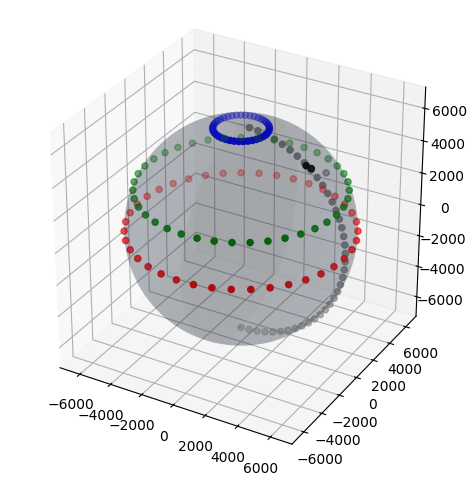

In [17]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Sphere surface
lon, lat = np.mgrid[-90:90:100j, 0.0:360:100j]
x, y , z = lon_lat_to_3d(lon, lat)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color="#303E4F", alpha=0.2, linewidth=0)

# Parallels
xx_equator, yy_equator, zz_equator = lon_lat_to_3d(lon_at_equator_deg, lat_at_equator_deg)
ax.scatter(xx_equator, yy_equator, zz_equator, color="r",s=20)

xx_tropic, yy_tropic, zz_tropic = lon_lat_to_3d(lon_at_tropic_deg, lat_at_tropic_deg)
ax.scatter(xx_tropic , yy_tropic, zz_tropic, color="g",s=20)

xx_arctic, yy_arctic, zz_arctic = lon_lat_to_3d(lon_at_arctic_deg, lat_at_arctic_deg)
ax.scatter(xx_arctic, yy_arctic, zz_arctic, color="b",s=20)

# Meridian
xx_meridian, yy_meridian, zz_meridian = lon_lat_to_3d(lon_at_meridian_deg, lat_at_meridian_deg)
ax.scatter(xx_meridian, yy_meridian, zz_meridian, color="gray",s=20)

# Cities
cities = [lon_lat_london, lon_lat_paris, lon_lat_rome]
lon_cities = [a[0] for a in cities]
lat_cities = [a[1] for a in cities]
xx_cities, yy_cities, zz_cities = lon_lat_to_3d(lon_cities, lat_cities)
ax.scatter(xx_cities, yy_cities, zz_cities, color="k",s=20)

# Plot
ax.set_aspect("equal")
plt.tight_layout()
plt.show()


From the plot above we can see that all works as expected, including the fact that the points at the tropic of cancer, even if they have the same longitude spacing as the point on the equator, have a significantly smaller mutual distance. They obviously come close to each other when approaching the north pole, becoming a single point at the pole itself.

If we want to keep the same "horizontal distance" or the distance on the tropic of Cancer as we have it at the equator, then we have to consider a smaller radius (that is the radius that varies in function of the latitude and that is given by $R\cos(\varphi)$) instead of the radius at the equator (that is $R$).

The drawing below may convince you about the need to multiply by the cosine of the latitude to have the sought result.

![](images/radius_at_latitude.png){#fig-radius-at-latitude}


So now we know how to adjust for the number of points to maintain their distance equal while modulating the latitude.

In [18]:
def num_points_at_latitude(num_points, latitude_deg):
    return int(num_points * np.cos(np.radians(latitude_deg)))

# Create N equidistant points around the equator
lon_at_equator_deg = np.linspace(0, 360, N)[:-1]
lat_at_equator_deg = 0 * np.ones_like(lon_at_equator_deg)

# Create equidistant points around the tropic of cancer, as at the equator
N_tropic = num_points_at_latitude(N, 23.43617)
lon_at_tropic_deg = np.linspace(0, 360, N_tropic)[:-1]
lat_at_tropic_deg = 23.43617 * np.ones_like(lon_at_tropic_deg)

# Create equidistant points around the north pole, as at the equator
N_arctic = num_points_at_latitude(N, 76.25)
lon_at_arctic_deg = np.linspace(0, 360, N_arctic)[:-1]
lat_at_arctic_deg = 76.25 * np.ones_like(lon_at_arctic_deg)

print("number of points")
print(f"at the arctic: {N_arctic}")
print(f"at the tropic: {N_tropic}")
print(f"at the equator: {N}")

number of points
at the arctic: 9
at the tropic: 36
at the equator: 40


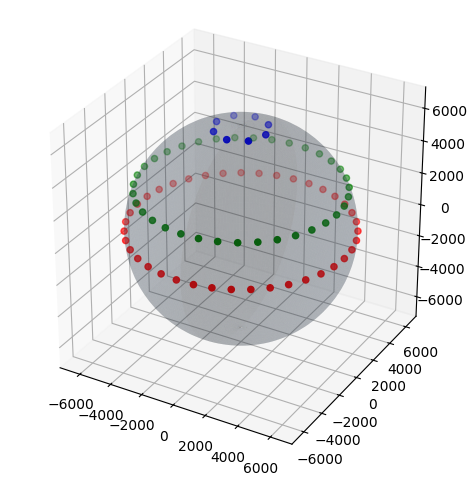

In [19]:
# Repeated code from cells above

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Sphere surface
lon, lat = np.mgrid[-90:90:100j, 0.0:360:100j]
x, y , z = lon_lat_to_3d(lon, lat)
ax.plot_surface(x, y, z,  rstride=1, cstride=1, color="#303E4F", alpha=0.2, linewidth=0)

# Parallels
xx_equator, yy_equator, zz_equator = lon_lat_to_3d(lon_at_equator_deg, lat_at_equator_deg)
ax.scatter(xx_equator, yy_equator, zz_equator, color="r",s=20)

xx_tropic, yy_tropic, zz_tropic = lon_lat_to_3d(lon_at_tropic_deg, lat_at_tropic_deg)
ax.scatter(xx_tropic , yy_tropic, zz_tropic, color="g",s=20)

xx_arctic, yy_arctic, zz_arctic = lon_lat_to_3d(lon_at_arctic_deg, lat_at_arctic_deg)
ax.scatter(xx_arctic, yy_arctic, zz_arctic, color="b",s=20)

# Plot
ax.set_aspect("equal")
plt.tight_layout()
plt.show()

## Two Points' Distance {#sec-two-points-distance}

As said above, latitude and longitude coordinates are independent from the chosen model. The model we use to project the coordinates becomes relevant for computing the distance between two points.

The Haversine distance is the shortest distance between two points in longitude and latitude coordinates on a spherical model. Its unit of measurement is the same as the one passed as input for the radius.

Before introducing the Haversine distance between $A = (\text{Lon}_{A}, \text{Lat}_{A})$ and $B = (\text{Lon}_{B}, \text{Lat}_{B})$, we start with two related concepts that can be seen as its approximation:

- **Euclidean distance** between the corresponding points on the sphere:
$$
d_{\text{Eucl}}(A, B) = \lVert \iota(\varphi_{A}, \theta_{A}) - \iota(\varphi_{A}, \theta_{A}) \rVert = \sqrt{(x_B - x_A)^2 + (y_B - y_A)^2 + (z_B - z_A)^2}
$$
The formula above simply leverages on the Pythagorean theorem in respect to the 3D coordinate axis, and represents the distance we would travel if we could dig a straight tunnel connecting $A$ and $B$. It always underestimate the distance on the sphere, in the worst case by a factor of $\pi \mathcal{R}$ for $\mathcal{R}$ earth radius.

The Euclidean distance is not very useful if we want to know the distance on the sphere! 

Can we adjust for the curvature of the sphere getting inspired by @fig-radius-at-latitude? For example we use the Pythagorean theorem on the surface of the sphere respect to the meridians and the parallels, and adjust for the fact that the latitude distance shrinks when moving away from the equator.

![](images/eucliean_spherical_distance.png){#fig-eucliean-spherical}


- **Distance of two points along the same meridian:** introducing the point $P = (\text{Lon}_{B}, \text{Lat}_{A})$ that makes $\bigtriangleup APB$ a right triangle on the surface of the sphere, the arch $\hat{BP}$ runs along a meridian, and its length, converted to $\text{Km}$ for the radius $\mathcal{R} = 6371~\text{Km}$ is given by:
$$
\hat{BP} = \frac{2\pi \mathcal{R}}{360^{o}}\left\vert \text{Lat}_{B} - \text{Lat}_{P}\right\vert 
= \frac{2\pi \mathcal{R}}{360^{o}}\vert \text{Lat}_{B} - \text{Lat}_{A}\vert
$$

- **Distance of two points along the same parallel:** as we saw, the distance along the arch $\hat{AP}$ is reduced by the cosine of the latitude, hence: 
$$
\hat{AP} = \frac{2\pi \mathcal{R} \cos(\text{rad}(\text{Lat}_{A}))}{360^{o}}\left\vert \text{Lon}_{A} - \text{Lon}_{P}\right\vert
= \frac{2\pi \mathcal{R} \cos(\text{rad}(\text{Lat}_{A}))}{360^{o}}\vert \text{Lon}_{A} - \text{Lon}_{B}\vert
$$

And so we can use again the Pythagorean theorem to compute $\hat{AB}$ as an Euclidean-spherical distance:

$$
d_{\text{Sph}}(A, B) = \sqrt{\hat{AP}^ 2 + \hat{BP}^2} 
= \frac{2\pi \mathcal{R}}{360^{o}} \sqrt{ \cos^2(\text{rad}(\text{Lat}_{A}))(\text{Lon}_{A} - \text{Lon}_{B})^2 + (\text{Lat}_{A} - \text{Lat}_{B})^2  }
$$

This too is an approximation. Even if the lenghts of the sides of the triangle are exact, the curvature of the trajectory $\hat{AB}$ itself is not taken into account. 

## Haversine Distance {#sec-haversine-distance}

The examples proposed above are useful to develop some geometrical intuition about the distances on the sphere. The Haversine distance, provides us with a closed form solution to compute the length of the *geodesic* curve on the sphere, which is the shortest path on the surface of the sphere between the point $A$ and $B$.

Thanks to the already mentioned symmetry, the geodesics is the arch defined by the intersection between the sphere and the plane passing through $A$, $B$ and the centre of the sphere. This plane always cuts the sphere in half, and again by symmetry, and rotating the sphere so that $A$ and $B$ are on the equator, it is easy to see why a curve made in this way is the shortest one (or why any other curve would be longer).

![](images/geodesic_on_the_sphere.png){#fig-radius-at-latitude}


Let $d$ be the sought geodesic distance between $A$ and $B$, and $\lambda$ the angle at the center of the sphere in radians. By definition of radians we have:

$$
\frac{d}{\mathcal{R}} = \lambda
$$
$$
\frac{d}{\mathcal{R}} = 2 \frac{\lambda}{2}
$$
$$
\frac{d}{\mathcal{R}} = 2 \arcsin \left(\sqrt{\sin^2(\lambda / 2 )}\right)
$$
$$
d = 2 \mathcal{R} \arcsin \left(\sqrt{\sin^2(\lambda / 2 )}\right)
$$
$$
d = 2 \mathcal{R} \arcsin \left(\sqrt{ \text{hav}(\lambda) }\right)
$${#eq-d-0}
Where $h$ is the **Haversine function** given by:
$$
\text{hav}(\lambda) := \sin^2\left(\frac{\lambda}{2}\right) = \frac{1 - \cos(\lambda)}{2}~.
$${#eq-hav-0}

The haversine function is particularly handy when we want to avoid computing a $\cos$, and to transform it into a $\sin$ function. Since the $\cos$ for small angle is numerically unstable, given a $\lambda$ we can chose if we want to compute $\text{hav}{\lambda}$ via the $\sin$ or the $\cos$ according to the numerical stability we want to obtain. 

From @eq-d-0 with the definition of the haversine function and some derivations detailed afterwards, we can get:
$$
d = 2 \mathcal{R} \arcsin 
\left(
    \left[  
        \text{hav}(\varphi_B - \varphi_A) + \cos\varphi_A \cos\varphi_B ~\text{hav}(\theta_B - \theta_A)
    \right]^{1/2}
\right) \\
$${#eq-hav-dist-1}
And equivalently
$$
d = 2 \mathcal{R} \arcsin 
\left(
    \left[  
        \text{hav}(\varphi_B - \varphi_A) + (1 - \text{hav}(\varphi_B - \varphi_A) - \text{hav}(\varphi_B + \varphi_A) ) \text{hav}(\theta_B - \theta_A)
    \right]^{1/2}
\right)
$${#eq-hav-dist-2}


Where the last two equations are a consequence of the following ones, that are still to be proven:
$$
\text{hav}(\lambda) = 
        \text{hav}(\varphi_B - \varphi_A) + \cos\varphi_A \cos\varphi_B ~\text{hav}(\theta_B - \theta_A)
$${#eq-hav-1}
and 
$$
\text{hav}(\lambda) = 
        \text{hav}(\varphi_B - \varphi_A) + (1 - \text{hav}(\varphi_B - \varphi_A) - \text{hav}(\varphi_B + \varphi_A) ) \text{hav}(\theta_B - \theta_A)
$${#eq-hav-2}


#### Proof of @eq-hav-1

**Hypothesis:** $A$ and $B$ points on the surface of a sphere, with coordinates 

$A=(\theta_A, \varphi_A) = (\cos\theta_A~\cos\varphi_A, \sin\theta_A~\cos\varphi_A, \sin\varphi_A )$ and 

$B=(\theta_B, \varphi_B) = (\cos\theta_B~\cos\varphi_B, \sin\theta_B~\cos\varphi_B, \sin\varphi_B )$ 

and $\lambda$ angle at the centre of the sphere.

**Thesis:** $\text{hav}(\lambda) = \text{hav}(\varphi_B - \varphi_A) + \cos\varphi_A \cos\varphi_B ~\text{hav}(\theta_B - \theta_A)$.

It is always possible to rotate the axis so to have $\theta_A = 0$, and $\tilde{\theta}_B = \theta_B - \theta_A$. In the new coordinate system we have:
$$
\begin{align*}
A &= (\cos\varphi_A, 0, \sin\varphi_A ) \\
B &=(\cos\tilde{\theta}_B~\cos\varphi_B, \sin\tilde{\theta}_B~\cos\varphi_B, \sin\varphi_B )
\end{align*}
$$

Now, how do we connect the angle $\lambda$ with $A$ and $B$?

With the scalar product, of course! 

Then we can add and subtract a ghost term and apply the addition subtraction formulae:
$$
\begin{align*}
\cos\lambda &= A \cdot B \\
&= \cos\varphi_A~\cos\tilde{\theta}_B~\cos\varphi_B + \sin\varphi_A~\sin\varphi_B \\
&= \cos\varphi_A~\cos\tilde{\theta}_B~\cos\varphi_B + \sin\varphi_A~\sin\varphi_B + \cos\varphi_A~\cos\varphi_B -  \cos\varphi_A~\cos\varphi_B \\
&= \cos\varphi_A~\cos\varphi_B(\cos\tilde{\theta}_B - 1) + \cos(\varphi_A - \varphi_B)
\end{align*}
$$
With simple algebraic manipulations the previous equation becomes:
$$
\begin{align*}
\frac{1 - \cos\lambda}{2} 
= \frac{1 - \cos(\varphi_A - \varphi_B)}{2} - \frac{1}{2}  \cos\varphi_A~\cos\varphi_B(\cos\tilde{\theta}_B - 1)
\end{align*}
$$
and considering that for any angle $\alpha$ we have $\cos(\alpha) = \cos(-\alpha)$, the previous equation is equivalent to the sought thesis:
$$
\text{hav}(\lambda) = \text{hav}(\varphi_B - \varphi_A) + \cos\varphi_A \cos\varphi_B ~\text{hav}(\theta_B - \theta_A)
$$



#### Proof of @eq-hav-2

Under the hypothesis of the previous proof, the **thesis** reduces to $\cos\varphi_A \cos\varphi_B = 1 - \text{hav}(\varphi_B - \varphi_A) - \text{hav}(\varphi_B + \varphi_A)$.

The proof starts and end as a direct consequence of the [addition subtraction formulae](https://en.wikibooks.org/wiki/Trigonometry/Addition_Formula_for_Cosines):
$$
\begin{align*}
\cos\varphi_A \cos\varphi_B 
&= \frac{1}{2}\left(  \cos(\varphi_B - \varphi_A) + \cos(\varphi_B + \varphi_A) \right) \\
&= 1 - \frac{1}{2} - \frac{1}{2} + \frac{\cos(\varphi_B - \varphi_A)}{2} + \frac{\cos(\varphi_B + \varphi_A)}{2} \\
&= 1  - \frac{ 1 - \cos(\varphi_B - \varphi_A)}{2} - \frac{1 - \cos(\varphi_B + \varphi_A)}{2} \\
&= 1  - \text{hav}(\varphi_B - \varphi_A) - \text{hav}(\varphi_B + \varphi_A) \\
\end{align*}
$$
which concludes the proof of the Haversine formula.

## Implementation and examples {#sec-implementation}

From a computational point of view, as sadi before, we want to avoid computing $\sin$ when the angles are very small. So a stable implementation would use the last part of @eq-hav-0.

In [20]:
""" Haversine function in python"""

def hav_function_sin(theta_A, phi_A, theta_B, phi_B):
    # haversine computed with the sin
    hav_rad = lambda  x: np.sin(x/2) ** 2
    return hav_rad(phi_B - phi_A) + (1 - hav_rad(phi_B - phi_A) - hav_rad(phi_B + phi_A) ) * hav_rad(theta_B - theta_A)

def haversine_distance_sin(lon_1, lat_1, lon_2, lat_2):
    theta_1, phi_1, theta_2, phi_2 = map(np.radians, [lon_1, lat_1, lon_2, lat_2])
    return 2 * R_Km * np.arcsin(np.sqrt(hav_function_sin(theta_1, phi_1, theta_2, phi_2)))

In [21]:
# Verify that it looks correct:
PREC = 6
print(f"Distance London to London = {round(haversine_distance_sin(*lon_lat_london, *lon_lat_london), PREC)} Km")
print(f"Distance London to Paris  = {round(haversine_distance_sin(*lon_lat_london, *lon_lat_paris), PREC)} Km")
print(f"Distance Paris to London  = {round(haversine_distance_sin(*lon_lat_paris, *lon_lat_london), PREC)} Km")

Distance London to London = 0.0 Km
Distance London to Paris  = 334.563443 Km
Distance Paris to London  = 334.563443 Km


It seems to be working correctly. Let's compare it with an out of the box function from the library `sklearn` (see also this [stack overflow discussion](https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points) and [this one](https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude))

In [22]:
from sklearn.metrics.pairwise import haversine_distances as haversine_distances_sklearn

lon_A, lat_A = lon_lat_london
lon_B, lat_B = lon_lat_paris
vals = [[np.radians(lat_A), np.radians(lon_A)], [np.radians(lat_B), np.radians(lon_B)]]
distance_sklearn = R_Km * haversine_distances_sklearn(vals)

print(f"Distance London to Paris for sklearn  = {round(distance_sklearn[1,0], PREC)} Km")

Distance London to Paris for sklearn  = 334.563443 Km


## Numerical stability {#sec-numerical-stability}

Let's see what happens in term of numerical stability. We take now two points in london very close to each others:


In [23]:
lon_lat_london_1 = (0.1276, 51.5072)
lon_lat_london_2 = (0.1276, 51.50720001)
PREC = 20

print(f"Very small distance (hav with sin) = {round(haversine_distance_sin(*lon_lat_london_1, *lon_lat_london_2), PREC)} Km")

Very small distance (hav with sin) = 1.11194938401393e-06 Km


We can see that our implementation with the haversine function, computed with the `sin` version, does not collapse to zero.

What happens if we re-implement with function with the cosine?

In [24]:
# repeated code with a small change. Now the Haversine function is computed with the cosine

def hav_function_cos(theta_A, phi_A, theta_B, phi_B):
    # Haversine computed with the cosine - Numerically unstable!
    hav_rad = lambda  x: (1-np.cos(x))/2
    return hav_rad(phi_B - phi_A) + (1 - hav_rad(phi_B - phi_A) - hav_rad(phi_B + phi_A) ) * hav_rad(theta_B - theta_A)

def haversine_distance_cos(lon_1, lat_1, lon_2, lat_2):
    theta_1, phi_1, theta_2, phi_2 = map(np.radians, [lon_1, lat_1, lon_2, lat_2])
    return 2 * R_Km * np.arcsin(np.sqrt(hav_function_cos(theta_1, phi_1, theta_2, phi_2)))

In [25]:
print(f"Distance London to Paris (hav with cos) = {round(haversine_distance_cos(*lon_lat_london, *lon_lat_paris), PREC)} Km")
print(f"Very small distance (hav with cos)      = {round(haversine_distance_cos(*lon_lat_london_1, *lon_lat_london_2), PREC)} Km")
print(f"Very small distance (hav with sin)      = {round(haversine_distance_sin(*lon_lat_london_1, *lon_lat_london_2), PREC)} Km")

Distance London to Paris (hav with cos) = 334.5634431209046 Km
Very small distance (hav with cos)      = 0.0 Km
Very small distance (hav with sin)      = 1.11194938401393e-06 Km


The function works well for large angles, though for small angle the Haversine distance computed with the cosine collapses.

Had the developers of `sklearn` use the `sin` or the `cos`?

In [26]:
lon_A, lat_A = lon_lat_london_1
lon_B, lat_B = lon_lat_london_2
vals = [[np.radians(lat_A), np.radians(lon_A)], [np.radians(lat_B), np.radians(lon_B)]]
dist_sklearn = R_Km * haversine_distances_sklearn(vals)

PREC = 20

print(f"Very small distance for sklearn  = {round(dist_sklearn[1,0], PREC)} Km")

Very small distance for sklearn  = 1.11194938401393e-06 Km


We can see that (at least for this case) our results and the `sklearn` implementation are the same! And we may even daring to assume that `sklearn` implemented the haversine distance with the `sin` formula.

## See also: Vincenty's formula {#sec-vincentry-formula}

To compute the distance between two points on an ellipsoid model (which is more accurate than the spherical model on which the Haversine is based on) there is the Vincenty formula [^2]. 

Its mathematical derivation may be the topic for another post, though if you want to have it computed with a tool out of the box, we recommend the library `geopy`.

[^2]: The original Vincenty's paper by  can be found [here](https://www.ngs.noaa.gov/wp-content/uploads/2018/12/inverse.pdf)

In [27]:
from geopy import distance

lon_A, lat_A = lon_lat_london
lon_B, lat_B = lon_lat_paris
vals = [[np.radians(lat_A), np.radians(lon_A)], [np.radians(lat_B), np.radians(lon_B)]]

dist_sklearn = R_Km * haversine_distances_sklearn(vals)
dist_vincenty = distance.distance(lon_lat_london[::-1], lon_lat_paris[::-1]).km

PREC = 6

print(f"Distance with haversine (sklearn) =  {round(dist_sklearn[1,0], PREC)} Km")
print(f"Distance with Vincenty (geopy)    =  {round(dist_vincenty, PREC)} Km")
print(f"Relative error = |ground - calculated|/|ground| = {round(100 * abs(dist_vincenty - dist_sklearn[1,0]) / dist_vincenty, PREC)} %")

Distance with haversine (sklearn) =  334.563443 Km
Distance with Vincenty (geopy)    =  334.883889 Km
Relative error = |ground - calculated|/|ground| = 0.095689 %
